In [1]:
import torch
import sklearn
import pandas as pd
import csv

In [2]:
SpamHam = pd.read_csv('/kaggle/input/spam-mails-dataset/spam_ham_dataset.csv')
SpamHam.head(5)

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [3]:
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

SpamHam['clean_text'] = SpamHam['text'].apply(clean_text)
SpamHam['clean_text'].head(5)


0    subject enron methanol meter this is a follow ...
1    subject hpl nom for january see attached file ...
2    subject neon retreat ho ho ho we re around to ...
3    subject photoshop windows office cheap main tr...
4    subject re indian springs this deal is to book...
Name: clean_text, dtype: object

In [4]:
def create_vocab(texts):
    vocab = set()
    for text in texts:
        words = text.split()
        vocab.update(words)
    return {word: idx for idx, word in enumerate(sorted(vocab))}

def text_to_bow(text, vocab):
    vector = torch.zeros(len(vocab))
    for word in text.split():
        if word in vocab:
            vector[vocab[word]] += 1
    return vector

vocabulary = create_vocab(SpamHam['clean_text'])
X = torch.stack([text_to_bow(text, vocabulary) for text in SpamHam['clean_text']])
y = torch.tensor(SpamHam['label_num'].values)


# XGBoost

In [5]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X.numpy(), y.numpy(), test_size=0.2, random_state=42
)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)

preds = model.predict(dtest)
y_pred = (preds > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

Accuracy: 0.9729

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       742
           1       0.93      0.97      0.95       293

    accuracy                           0.97      1035
   macro avg       0.96      0.97      0.97      1035
weighted avg       0.97      0.97      0.97      1035



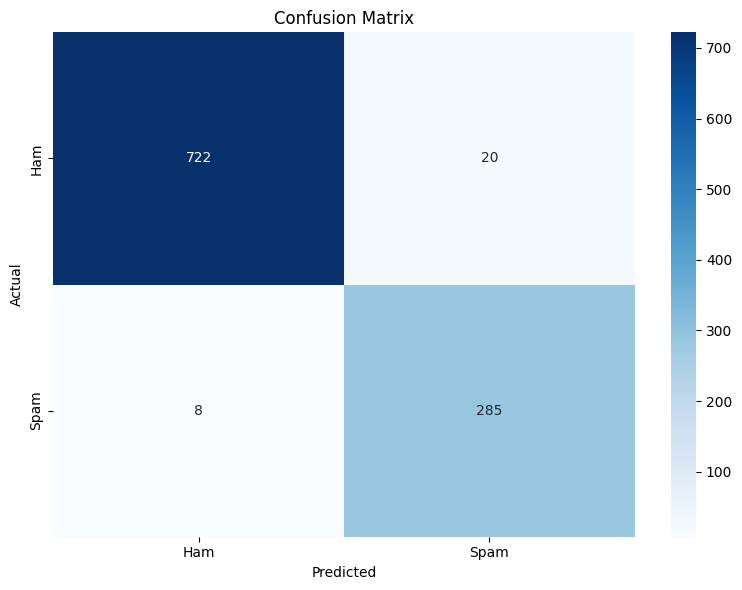

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], 
            yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()

